## Computing the variance of the coefficients in the BFE:


### to-do:

- Covariance matrix for 1e6 and 1e8 terms 
- Compute smoothing of those terms
- How many of the most smoothed terms correspond to the less energetic terms
- Compare accelerations
- Do cuts in accelerations to see how many terms I need.
- For computing orbits the best way will be to minimize the accelerations. However, for time -dependent analysis it is no clear yet if just cuts in energies will be good. 
- Compute $\Delta a$ with the smoothed coefficients and see how good it does. See to what energy levels cuts it corresponds to.
- Plot the density  + potential of the less energetic terms and of the most smoothed terms.. is this noise?


In [1]:
%pylab inline
import biff
from scipy import special
import pygadgetreader
import reading_snapshots
#import gala
from gadget_read_snap import read_snap

Populating the interactive namespace from numpy and matplotlib


In [2]:
# cuts on smoothed terms..

In [3]:
r_s_sims = 40.85
G_gadget=43007.1 #kpc3/(Gyr2Msun)/1E10. 

In [4]:
font = {'size':18, 'family':'serif'}
matplotlib.rc('font', **font)


In [5]:

def Anl(n, l):
    knl = 0.5*n*(n+4*l+3) + (l+1)*(2*l+1)
    A_nl = - 2**(8*l+6)/(4*np.pi*knl) * (special.factorial(n)*(n+2*l+3/2.)*(special.gamma(2*l+3/2.))**2)/(special.gamma(n+4*l+3))
    return A_nl


def smoothing(cov_matrix, coeff, m):
    """
    Coefficients smoothing 
    
    """
    var_coeff = (cov_matrix - m*coeff**2)
    b_nlm = 1/(1 + var_coeff/coeff**2)
    # This line remove nans an put the original values
    b_nlm_values = np.nan_to_num(b_nlm)
    return b_nlm_values

In [25]:
data = loadtxt('./MW/MW_100M_b1_dm_part_1e6.txt')

In [26]:
posx = data[:,0]
posy = data[:,1]
posz = data[:,2]
mass = data[:,3]

In [27]:
pos = np.array([posx, posy, posz]).T

In [28]:
S_mwlmc, T_mwlmc = biff.compute_coeffs_discrete(np.double(pos), mass, 20, 2, 
                                                      skip_m=False, r_s=40.85, compute_var=True)

In [35]:
T_mwlmc[1][1][2][2]

8.4391541661255771e-07

In [23]:
b_smooth_S = smoothing(S_mwlmc[1], S_mwlmc[0], mass[0])
b_smooth_T = smoothing(T_mwlmc[1], T_mwlmc[0], mass[0])

/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [83]:
## Reading coefficients 
coeff_c = np.loadtxt('MW/MW_bfe_b1_1e6.txt')
S_mw_1e6 = coeff_c[:,0]
T_mw_1e6 = coeff_c[:,1]

S_matrix_mw_1e6 = np.zeros((21, 21, 21))
T_matrix_mw_1e6 = np.zeros((21, 21, 21))


counter = 0
for n in range(21):
    for l in range(21):
        for m in range(0, l+1):
            S_matrix_mw_1e6[n][l][m] = S_mw_1e6[counter]
            T_matrix_mw_1e6[n][l][m] = T_mw_1e6[counter]
            counter +=1

In [533]:
## Reading coefficients 
coeff_c = np.loadtxt('MW/MW_bfe_b1_1e8.txt')
S_mw_1e8 = coeff_c[:,0]
T_mw_1e8 = coeff_c[:,1]

S_matrix_mw_1e8 = np.zeros((21, 21, 21))
T_matrix_mw_1e8 = np.zeros((21, 21, 21))


counter = 0
for n in range(21):
    for l in range(21):
        for m in range(0, l+1):
            S_matrix_mw_1e8[n][l][m] = S_mw_1e6[counter]
            T_matrix_mw_1e8[n][l][m] = T_mw_1e6[counter]
            counter +=1

In [94]:
np.log10(np.abs(S_matrix_mw_1e6[10][1][0]))

/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


-inf

In [36]:
## Reading coefficients 
coeff_c = np.loadtxt('covariance_mw_100M_b1_dm_part1e6.txt')
Scov_mw_1e6 = coeff_c[:,0]
Tcov_mw_1e6 = coeff_c[:,1]

Scov_matrix_mw_1e6 = np.zeros((21, 21, 21))
Tcov_matrix_mw_1e6 = np.zeros((21, 21, 21))


counter = 0
for n in range(21):
    for l in range(21):
        for m in range(0, l+1):
            Scov_matrix_mw_1e6[n][l][m] = Scov_mw_1e6[counter]
            Tcov_matrix_mw_1e6[n][l][m] = Tcov_mw_1e6[counter]
            counter +=1

In [531]:
coeff_c = np.loadtxt('covariance_mwlmc5_b1_1e8.txt')
Scov_mw_1e8 = coeff_c[:,0]
Tcov_mw_1e8 = coeff_c[:,1]

Scov_matrix_mw_1e8 = np.zeros((21, 3, 3))
Tcov_matrix_mw_1e8 = np.zeros((21, 3, 3))


counter = 0
for n in range(21):
    for l in range(3):
        for m in range(0, l+1):
            Scov_matrix_mw_1e8[n][l][m] = Scov_mw_1e8[counter]
            Tcov_matrix_mw_1e8[n][l][m] = Tcov_mw_1e8[counter]
            counter +=1

In [40]:
b_smooth_S_1e6 = smoothing(Scov_matrix_mw_1e6, S_matrix_mw_1e6, mass[0])
b_smooth_T_1e6 = smoothing(Tcov_matrix_mw_1e6, T_matrix_mw_1e6, mass[0])


/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [535]:
b_smooth_S_1e8 = smoothing(Scov_matrix_mw_1e8, S_matrix_mw_1e8[:,:3,:3], mass[0])
b_smooth_T_1e8 = smoothing(Tcov_matrix_mw_1e8, T_matrix_mw_1e8[:,:3,:3], mass[0])


/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [41]:
n_max = l_max = m_max = 21
A_nl_array = np.zeros((n_max, l_max))
for j in range(n_max):
    for i in range(l_max):
        A_nl_array[j][i] = Anl(j, i)
A_nl_matrix = np.zeros((n_max, l_max, m_max))
for i in range(m_max):
    A_nl_matrix[:,:,i] = A_nl_array

In [537]:
U_mwlmc8 = -0.5 * (S_matrix_mw_1e8**2 + T_matrix_mw_1e8**2)/A_nl_matrix

In [44]:
U_mwlmc6 = -0.5 * (S_matrix_mw_1e6**2 + T_matrix_mw_1e6**2)/A_nl_matrix

In [43]:
U_smooth = -0.5 * (b_smooth_S_1e6*S_matrix_mw_1e6**2 + b_smooth_T_1e6*T_matrix_mw_1e6**2)/A_nl_matrix

In [540]:
U_smooth_8 = -0.5 * (b_smooth_S_1e8*S_matrix_mw_1e8[:,:3,:3]**2 + b_smooth_T_1e8*T_matrix_mw_1e8[:,:3,:3]**2)/A_nl_matrix[:,:3,:3]

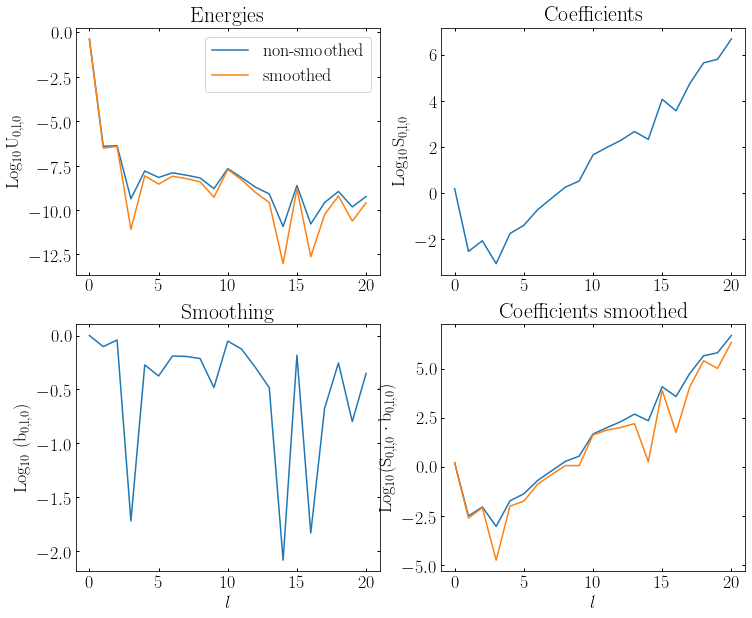

In [321]:
for i in range(1):
    figure(figsize=(12, 10))

    subplot(2, 2, 1)
    title('Energies')
    plot(np.log10(U_mwlmc6[i,:,0]), label='non-smoothed')
    plot(np.log10(U_smooth[i,:,0]), label='smoothed')
    legend()
    ylabel(r'$\rm{Log_{10}}U_{0,l,0}$')

    subplot(2, 2, 2)
    title('Coefficients')
    plot(np.log10(np.abs(S_matrix_mw_1e6[i,:,0])), label=r'$l=0')
    ylabel(r'$\rm{Log_{10}}S_{0,l,0}$')


    subplot(2, 2, 3)
    title('Smoothing')
    plot(np.log10(b_smooth_S_1e6[i,:,0]), label=r'$l=0')
    xlabel('$l$')
    ylabel(r'$\rm{Log_{10}}\ (b_{0,l,0})$')


    subplot(2, 2, 4)
    title('Coefficients smoothed')
    plot(np.log10(np.abs(S_matrix_mw_1e6[i,:,0])), label=r'$l=0')
    plot(np.log10(b_smooth_S_1e6[i,:,0]*np.abs(S_matrix_mw_1e6[i,:,0])), label=r'$l=0')
    ylabel(r'$\rm{Log_{10}} (S_{0,l,0}\cdot b_{0,l,0})$')
    xlabel('$l$')

    #savefig('energies_smoothed_n_{}.pdf'.format(i))
    #close()

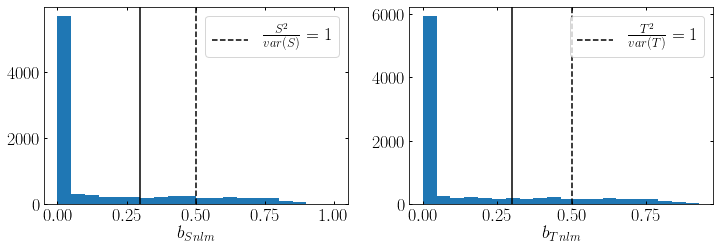

In [592]:
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(2,2,1)
h1 = ax1.hist(b_smooth_S_1e6.flatten(), 20, color='C0')
ax1.set_xlabel(r'$b_S_{nlm}$')
ax1.axvline(0.3, c='k')
ax1.axvline(0.5, c='k', ls='--', label=r'$\frac{S^2}{var(S)}=1$')
ax1.legend()

ax2 = fig.add_subplot(2,2,2)
h2 = ax2.hist(b_smooth_T_1e6.flatten(), 20, color='C0')
ax2.set_xlabel(r'$b_T_{nlm}$')
ax2.axvline(0.5, c='k', ls='--', label=r'$\frac{T^2}{var(T)}=1$')
ax2.axvline(0.3, c='k')
ax2.legend()

savefig('smoothing.pdf', bbox_inches='tight')

In [323]:
index_s_cut = np.where(b_smooth_S_1e6<0.3)
index_t_cut = np.where(b_smooth_T_1e6<0.3)

In [324]:
len(index_s_cut[0])

6934

In [328]:
len(b_smooth_S_1e6.flatten())

9261

In [325]:
len(index_t_cut[0])

7109

In [543]:
## Energy cuts
def copy_matrix(M, indices):
    M_new = np.zeros(shape(M))
    for i in range(len(indices[0])):
        M_new[indices[0][i]][indices[1][i]][indices[2][i]] = M[indices[0][i]][indices[1][i]][indices[2][i]]
    return M_new

def coefficients_energy_level(S, T, e_cut, verb=0):
    """
    Returns coefficients with energy higher than e_cut
    e_cut : float 
        between 0 and 1
        
    """
    n_max = shape(S)[0]
    l_max = shape(S)[1]
    m_max = shape(S)[2]
    
    
    A_nl_array = np.zeros((n_max, l_max))
    for j in range(n_max):
        for i in range(l_max):
            A_nl_array[j][i] = Anl(j, i)
    A_nl_matrix = np.zeros((n_max, l_max, m_max))
    for i in range(m_max):
        A_nl_matrix[:,:,i] = A_nl_array
    
    U_nlm = 0.5*(S**2 + T**2)/A_nl_matrix
    U_all = np.sum(U_nlm)
    energy_cut = np.where(np.log10(np.abs(U_nlm))>e_cut)
    if verb == 1:
        print('\sum U = ',np.log10(np.abs(U_all)))
        print('U cut = ',np.log10(np.abs(U_all))*e_cut)
        print('N coeff = ', len(energy_cut[0]))

    S_new = copy_matrix(S, energy_cut)
    T_new = copy_matrix(T, energy_cut)
    return S_new, T_new, [np.max(energy_cut[0]) ,np.max(energy_cut[1]), np.max(energy_cut[2]), len(energy_cut[0])]
    
def coefficients_smooth_level(S, T, bs, bt, b_cut, verb=0):
    """
    Returns coefficients with energy higher than e_cut
    e_cut : float 
        between 0 and 1
        
    """
 
    bs_cut_index = np.where(bs>b_cut)
    bt_cut_index = np.where(bt>b_cut)
    
    if verb == 1:

        print('N coeff S= ', len(bs_cut_index[0]))
        print('N coeff T= ', len(bt_cut_index[0]))

    S_new = copy_matrix(S, bs_cut_index)
    T_new = copy_matrix(T, bt_cut_index)
    return S_new, T_new, len(bs_cut_index[0])
    

def N_energy_level(S, T, N, verb=0):
    """
    Returns coefficients with energy higher than e_cut
    e_cut : float 
        between 0 and 1
        
    """
    n_max = shape(S)[0]
    l_max = shape(S)[1]
    m_max = shape(S)[2]
    
    
    A_nl_array = np.zeros((n_max, l_max))
    for j in range(n_max):
        for i in range(l_max):
            A_nl_array[j][i] = Anl(j, i)
    A_nl_matrix = np.zeros((n_max, l_max, m_max))
    for i in range(m_max):
        A_nl_matrix[:,:,i] = A_nl_array
    
    U_nlm = -0.5*(S**2 + T**2)/A_nl_matrix
    U_nlm_sort = np.sort(U_nlm.flatten())
    U_cut = U_nlm_sort[::-1][N]
    energy_cut = np.where(U_nlm>U_cut)
    if verb == 1:
        print('N coeff = ', len(energy_cut[0]))

    S_new = copy_matrix(S, energy_cut)
    T_new = copy_matrix(T, energy_cut)
    return S_new, T_new

In [475]:
nterms = 0
for i in range(0, 21):
    for j in range(0, 21):
        for k in range(0, j+1):
            nterms +=1

In [476]:
nterms

4851

In [496]:
x = np.sort(U_mwlmc6.flatten())

In [497]:
x[::-1]

array([  4.14895658e-01,   6.26988249e-06,   1.48610215e-06, ...,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00])

In [498]:
x[::-1][2327]

2.0418336933181729e-09

In [493]:
S_cut, T_cut, info = coefficients_energy_level(S_matrix_mw_1e6, T_matrix_mw_1e6, -8.7, 1)

\sum U =  -0.38202487905
U cut =  3.32361644773
N coeff =  2361


/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


In [590]:
S_cut_b, T_cut_b ,NN = coefficients_smooth_level(S_matrix_mw_1e6, T_matrix_mw_1e6, b_smooth_S_1e6, b_smooth_T_1e6, 0.95, verb=1)
print(NN)

N coeff S=  10
N coeff T=  0
10


In [527]:
S_cut_2, T_cut_2 = N_energy_level(S_matrix_mw_1e6, T_matrix_mw_1e6, 2756, verb=1)


N coeff =  2756


In [586]:
b_cuts = np.linspace(0.2, 1)
fraction = np.zeros(len(b_cuts))
for i in range(len(b_cuts)):
    S_cut_b, T_cut_b, N_coeff = coefficients_smooth_level(S_matrix_mw_1e6, T_matrix_mw_1e6, b_smooth_S_1e6, b_smooth_T_1e6, b_cuts[i], verb=1)
    S_cut_2, T_cut_2 = N_energy_level(S_matrix_mw_1e6, T_matrix_mw_1e6, N_coeff, verb=1)
    index_common = np.where((S_cut_b != 0)  & (S_cut_2 !=0)) 
    fraction[i] = len(index_common[0])/N_coeff
    

N coeff S=  2756
N coeff T=  2548
N coeff =  2756
N coeff S=  2692
N coeff T=  2474
N coeff =  2692
N coeff S=  2622
N coeff T=  2400
N coeff =  2622
N coeff S=  2550
N coeff T=  2343
N coeff =  2550
N coeff S=  2484
N coeff T=  2284
N coeff =  2484
N coeff S=  2406
N coeff T=  2224
N coeff =  2406
N coeff S=  2334
N coeff T=  2156
N coeff =  2334
N coeff S=  2270
N coeff T=  2084
N coeff =  2270
N coeff S=  2199
N coeff T=  2022
N coeff =  2199
N coeff S=  2132
N coeff T=  1971
N coeff =  2132
N coeff S=  2056
N coeff T=  1908
N coeff =  2056
N coeff S=  1991
N coeff T=  1842
N coeff =  1991
N coeff S=  1926
N coeff T=  1775
N coeff =  1926
N coeff S=  1856
N coeff T=  1704
N coeff =  1856
N coeff S=  1776
N coeff T=  1635
N coeff =  1776
N coeff S=  1689
N coeff T=  1561
N coeff =  1689
N coeff S=  1593
N coeff T=  1470
N coeff =  1593
N coeff S=  1520
N coeff T=  1403
N coeff =  1520
N coeff S=  1449
N coeff T=  1351
N coeff =  1449
N coeff S=  1388
N coeff T=  1297
N coeff =  1388


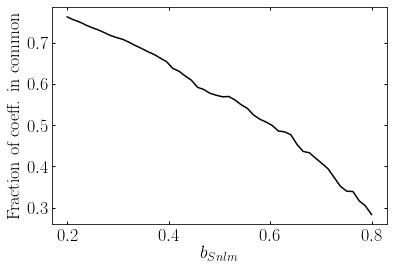

In [521]:
plot(b_cuts, fraction, c='k')
xlabel(r'$b_S_{nlm}$')
ylabel('Fraction of coeff. in common')
savefig('common_coeff.pdf', bbox_inches='tight')

In [600]:
N_coeff_ct[0]

2756.0

In [601]:
b_cuts = np.linspace(0.2, 1)
fraction_smooth = np.zeros(len(b_cuts))
N_coeff_ct = np.zeros(len(b_cuts))
for i in range(len(b_cuts)):
    S_cut_b, T_cut_b, N_coeff_ct[i] = coefficients_smooth_level(S_matrix_mw_1e6, T_matrix_mw_1e6, b_smooth_S_1e6, b_smooth_T_1e6, b_cuts[i], verb=1)
    S_cut_2, T_cut_2 = N_energy_level(S_matrix_mw_1e6*b_smooth_S_1e6, T_matrix_mw_1e6*b_smooth_T_1e6,
                                      int(N_coeff_ct[i]), verb=1)
    index_common = np.where((S_cut_b != 0)  & (S_cut_2 !=0)) 
    fraction_smooth[i] = len(index_common[0])/N_coeff_ct[i]

N coeff S=  2756
N coeff T=  2548
N coeff =  2756
N coeff S=  2692
N coeff T=  2474
N coeff =  2692
N coeff S=  2622
N coeff T=  2400
N coeff =  2622
N coeff S=  2550
N coeff T=  2343
N coeff =  2550
N coeff S=  2484
N coeff T=  2284
N coeff =  2484
N coeff S=  2406
N coeff T=  2224
N coeff =  2406
N coeff S=  2334
N coeff T=  2156
N coeff =  2334
N coeff S=  2270
N coeff T=  2084
N coeff =  2270
N coeff S=  2199
N coeff T=  2022
N coeff =  2199
N coeff S=  2132
N coeff T=  1971
N coeff =  2132
N coeff S=  2056
N coeff T=  1908
N coeff =  2056
N coeff S=  1991
N coeff T=  1842
N coeff =  1991
N coeff S=  1926
N coeff T=  1775
N coeff =  1926
N coeff S=  1856
N coeff T=  1704
N coeff =  1856
N coeff S=  1776
N coeff T=  1635
N coeff =  1776
N coeff S=  1689
N coeff T=  1561
N coeff =  1689
N coeff S=  1593
N coeff T=  1470
N coeff =  1593
N coeff S=  1520
N coeff T=  1403
N coeff =  1520
N coeff S=  1449
N coeff T=  1351
N coeff =  1449
N coeff S=  1388
N coeff T=  1297
N coeff =  1388


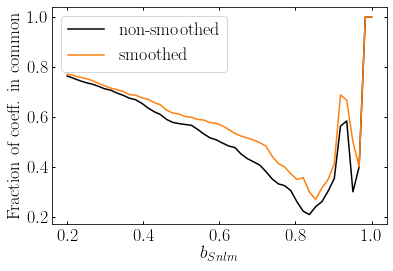

In [602]:
plot(b_cuts, fraction, c='k', label='non-smoothed')
plot(b_cuts, fraction_smooth, c='C1', label='smoothed')
xlabel(r'$b_S_{nlm}$')
ylabel('Fraction of coeff. in common')
legend()
#savefig('common_coeff.pdf', bbox_inches='tight')

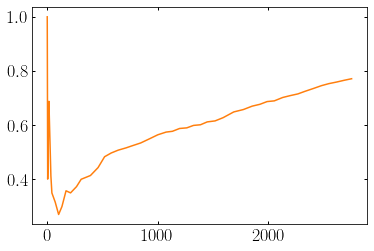

In [609]:
plot(N_coeff_ct, fraction_smooth, c='C1', label='smoothed')
#xlim(0, 30000)

/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


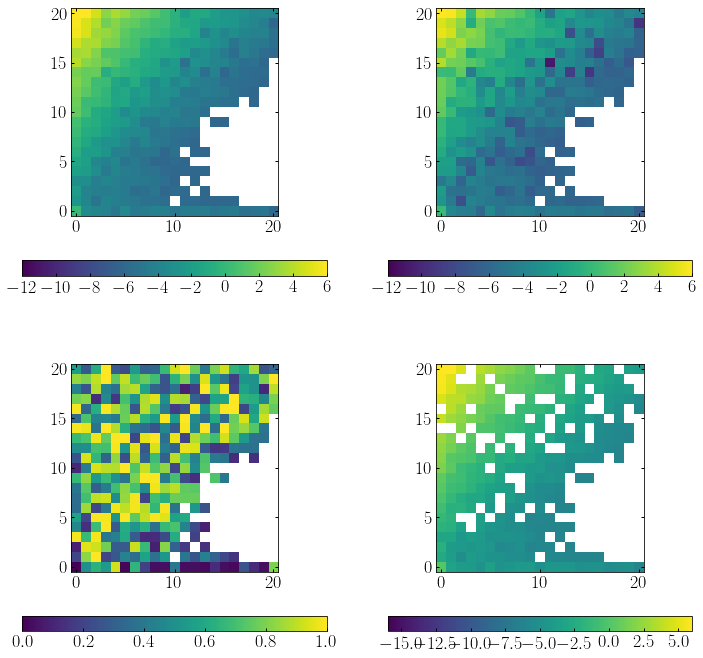

In [329]:
fig = plt.figure(figsize=(12, 12))

ax1 = fig.add_subplot(2,2,1)
im = ax1.imshow(np.log10(np.abs(S_matrix_mw_1e6[:,:,0])).T,origin='lower', vmin=-12, vmax=6)
colorbar(im, orientation='horizontal')

ax2 = fig.add_subplot(2,2,2)
im2 = ax2.imshow(np.log10(b_smooth_S_1e6[:,:,0]*np.abs(S_matrix_mw_1e6[:,:,0])).T,origin='lower',
                vmin=-12, vmax=6)
colorbar(im2, orientation='horizontal')

ax3 = fig.add_subplot(2,2,3)
im3 = ax3.imshow((np.abs(b_smooth_S_1e6[:,:,0]*S_matrix_mw_1e6[:,:,0] - S_matrix_mw_1e6[:,:,0])/np.abs(S_matrix_mw_1e6[:,:,0])).T,
                 origin='lower', vmin=0.0, vmax=1)
colorbar(im3, orientation='horizontal')

ax4 = fig.add_subplot(2,2,4)
im4 = ax4.imshow(np.log10(np.abs(S_cut[:,:,0])).T, origin='lower', vmin=-16, vmax=6)
colorbar(im4, orientation='horizontal')


In [ ]:
imshow(np.log10(b_smooth_S[:,:,0]*np.abs(S_mwlmc[0][:,:,0])).T,origin='lower')

## $\Delta a$ with smoothed coeff

In [545]:
snap_gadget_1e6 = read_snap('./MW/gadget3_MW5_100M_b1_dmhalopart_elgato_1e6_001')

256
12000000 blocksize pp
4000000 blocksize ids
4000000 blocksize mass


In [113]:
acc_gadget_1e6 = snap_gadget_1e6[2]
pos_gadget_1e6 = snap_gadget_1e6[0]
pot_gadget_1e6 = snap_gadget_1e6[1]

In [546]:
snap_gadget_1e8 = read_snap('./MW/gadget3_MWLMC5_100M_b1_dmhalopart_elgato_1e8_001')
acc_gadget_1e8 = snap_gadget_1e8[2]
pos_gadget_1e8 = snap_gadget_1e8[0]
pot_gadget_1e8 = snap_gadget_1e8[1]

256
1200000000 blocksize pp
400000000 blocksize ids
400000000 blocksize mass


In [161]:
N_rand_1e6 = np.random.randint(0, 1000000, 5000)

In [547]:
N_rand_1e8 = np.random.randint(0, 100000000, 5000)

In [162]:
r_sims_1e6 = (pos_gadget_1e6[:,0]**2 + pos_gadget_1e6[:,1]**2 + pos_gadget_1e6[:,2]**2)**0.5


In [549]:
r_sims_1e8 = (pos_gadget_1e8[:,0]**2 + pos_gadget_1e8[:,1]**2 + pos_gadget_1e8[:,2]**2)**0.5


In [163]:
a_all = biff.gradient(np.ascontiguousarray(np.double(pos_gadget_1e6[N_rand_1e6])), 
                    S_matrix_mw_1e6, T_matrix_mw_1e6, G=G_gadget, M=1, r_s=r_s_sims)

a_smooth = biff.gradient(np.ascontiguousarray(np.double(pos_gadget_1e6[N_rand_1e6])), 
                    S_matrix_mw_1e6*b_smooth_S_1e6, T_matrix_mw_1e6*b_smooth_T_1e6, 
                         G=G_gadget, M=1, r_s=r_s_sims)

In [138]:
a_vec_all = (a_all[:,0]**2 + a_all[:,1]**2 + a_all[:,2]**2)**0.5
a_smooth_all = (a_smooth[:,0]**2 + a_smooth[:,1]**2 + a_smooth[:,2]**2)**0.5
acc_gadget_1e6_all = (acc_gadget_1e6[:,0]**2 + acc_gadget_1e6[:,1]**2 + acc_gadget_1e6[:,2]**2)**0.5

In [551]:
a_all_8 = biff.gradient(np.ascontiguousarray(np.double(pos_gadget_1e8[N_rand_1e8])), 
                    S_matrix_mw_1e8, T_matrix_mw_1e8, G=G_gadget, M=1, r_s=r_s_sims)

a_smooth_8 = biff.gradient(np.ascontiguousarray(np.double(pos_gadget_1e8[N_rand_1e8])), 
                    S_matrix_mw_1e8[:,:3,:3]*b_smooth_S_1e8, T_matrix_mw_1e8[:,:3,:3]*b_smooth_T_1e8, 
                         G=G_gadget, M=1, r_s=r_s_sims)

In [552]:
a_vec_all8 = (a_all_8[:,0]**2 + a_all_8[:,1]**2 + a_all_8[:,2]**2)**0.5
a_smooth_all8 = (a_smooth_8[:,0]**2 + a_smooth_8[:,1]**2 + a_smooth_8[:,2]**2)**0.5
acc_gadget_1e8_all = (acc_gadget_1e8[:,0]**2 + acc_gadget_1e8[:,1]**2 + acc_gadget_1e8[:,2]**2)**0.5

(-10, 300)

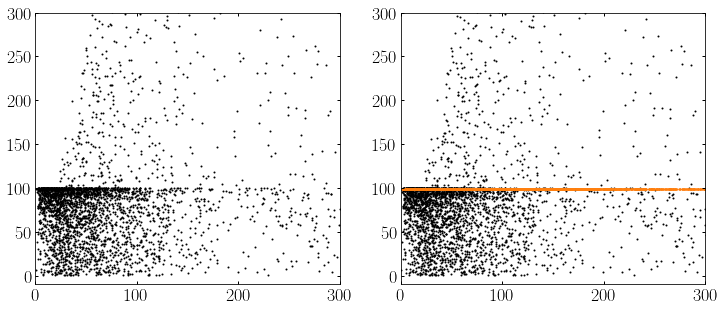

In [572]:
r_sort = argsort(r_sims_1e6[N_rand_1e6])
r_sort8 = argsort(r_sims_1e8[N_rand_1e8])

figure(figsize=(12, 5))
subplot(1, 2, 1)
scatter(r_sims_1e6[N_rand_1e6][r_sort], 
         100*(np.abs(a_vec_all[r_sort]-acc_gadget_1e6_all[N_rand_1e6][r_sort])/
                  np.abs(acc_gadget_1e6_all[N_rand_1e6][r_sort]))
        ,  color='k', alpha=1, label='$10^{6}$', s=1)


#scatter(r_sims_1e8[N_rand_1e8][r_sort8], 
#         100*(np.abs(a_vec_all8[r_sort8]-acc_gadget_1e8_all[N_rand_1e8][r_sort8])/
#                  np.abs(acc_gadget_1e8_all[N_rand_1e8][r_sort8]))
#        ,  color='C1', alpha=1, label='$10^{8}$', s=1)

xlim(0, 300)
ylim(-10, 300)
subplot(1, 2, 2)
scatter(r_sims_1e6[N_rand_1e6][r_sort], 
         100*np.abs(a_smooth_all[r_sort]-acc_gadget_1e6_all[N_rand_1e6][r_sort])/np.abs(acc_gadget_1e6_all[N_rand_1e6][r_sort])
        ,  color='k', alpha=1, label='$10^{6}$', s=1)

scatter(r_sims_1e8[N_rand_1e8][r_sort8], 
         100*np.abs(a_smooth_all8[r_sort8]-acc_gadget_1e8_all[N_rand_1e8][r_sort8])/np.abs(acc_gadget_1e8_all[N_rand_1e8][r_sort8])
        ,  color='C1', alpha=1, label='$10^{8}$', s=1)

xlim(0, 300)
ylim(-10, 300)

In [148]:
def a_r(r, a, bins, rmax):
    r_bin = np.linspace(min(r), rmax, bins)
    a_mean = np.zeros(bins)
    a_std = np.zeros(bins)
    for i in range(bins-1):
        dr = np.where((r>r_bin[i]) & (r<r_bin[i+1]))[0]
        a_mean[i] = np.nanmean(a[dr])
        a_std[i] = np.nanstd(a[dr])
    return r_bin, a_mean, a_std
        
        
    

In [150]:
rsmooth, a_smooth_mean, a_smooth_std = a_r(r_sims_1e6[N_rand_1e6], np.abs(a_smooth_all-acc_gadget_1e6_all[N_rand_1e6])
                                           /np.abs(acc_gadget_1e6_all[N_rand_1e6]), 20, 300)

In [570]:
rsmooth8, a_smooth_mean8, a_smooth_std8 = a_r(r_sims_1e8[N_rand_1e8], np.abs(a_smooth_all8-acc_gadget_1e8_all[N_rand_1e8])
                                           /np.abs(acc_gadget_1e8_all[N_rand_1e8]), 20, 300)

In [569]:
rsmooth8, a_all_mean8, a_all_std8 = a_r(r_sims_1e8[N_rand_1e8], np.abs(-a_all_8-acc_gadget_1e8[N_rand_1e8])
                                           /np.abs(acc_gadget_1e8[N_rand_1e8]), 20, 300)

Text(0,0.5,'$\\Delta a$')

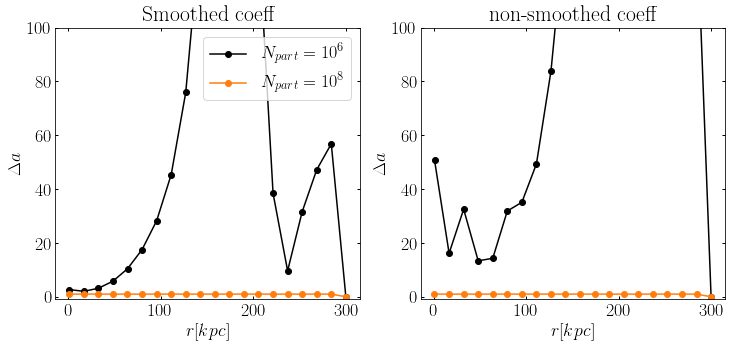

In [574]:
figure(figsize=(12, 5))
subplot(1, 2, 1)
title('Smoothed coeff')
plot(rsmooth, a_smooth_mean*100, '-o', label='$N_{part} = 10^6$', c='k')
plot(rsmooth8, a_smooth_mean8, '-o', label='$N_{part} = 10^8$', c='C1')

legend()
ylim(-1, 100)
xlabel(r'$r[kpc]$')
ylabel(r'$\Delta a$')


subplot(1, 2, 2)
title('non-smoothed coeff')
plot(rsmooth, a_all_mean*100, '-o', c='k')
plot(rsmooth8, a_all_mean8, '-o', c='C1')
ylim(-1, 100)
xlabel(r'$r[kpc]$')
ylabel(r'$\Delta a$')
#savefig('delta_a_ncoeff.pdf')

## Computing number of terms from error in acceleration

In [ ]:
def n_coeff_a_err(S, T, Scov, Tcov):
    # Compute smooth terms
    # Compute Energy of the smoothed terms
    # Compute accelerations
    

## density and potential of the less energetic terms

In [165]:
def coefficients_lowest_energy_level(S, T, e_cut, verb=0):
    """
    Returns coefficients with energy higher than e_cut
    e_cut : float 
        between 0 and 1
        
    """
    n_max = shape(S)[0]
    l_max = shape(S)[1]
    m_max = shape(S)[2]
    
    
    A_nl_array = np.zeros((n_max, l_max))
    for j in range(n_max):
        for i in range(l_max):
            A_nl_array[j][i] = Anl(j, i)
    A_nl_matrix = np.zeros((n_max, l_max, m_max))
    for i in range(m_max):
        A_nl_matrix[:,:,i] = A_nl_array
    
    U_nlm = 0.5*(S**2 + T**2)/A_nl_matrix
    U_all = np.sum(U_nlm)
    energy_cut = np.where(np.log10(np.abs(U_nlm))<e_cut)
    if verb == 1:
        print('\sum U = ',np.log10(np.abs(U_all)))
        print('U cut = ',np.log10(np.abs(U_all))*e_cut)
        print('N coeff = ', len(energy_cut[0]))

    S_new = copy_matrix(S, energy_cut)
    T_new = copy_matrix(T, energy_cut)
    return S_new, T_new, [np.max(energy_cut[0]) ,np.max(energy_cut[1]), np.max(energy_cut[2]), len(energy_cut[0])]
    
    

In [258]:
S_cut_low, T_cut_low, info = coefficients_lowest_energy_level(S_matrix_mw_1e6, T_matrix_mw_1e6, -12, 1)

\sum U =  -0.38202487905
U cut =  4.58429854859
N coeff =  4858


/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


In [259]:
y_grid = np.arange(-300, 300, 5)
z_grid = np.arange(-300, 300, 5)
y_grid, z_grid = meshgrid(y_grid, z_grid)


In [260]:
slice_xyz = np.ascontiguousarray(np.array([np.zeros(len(y_grid.flatten())), y_grid.flatten(), z_grid.flatten()]).T)

In [261]:
pot_low = biff.potential(slice_xyz, 
                    S_cut_low, T_cut_low, G=G_gadget, M=1, r_s=r_s_sims)


In [262]:
dens_low = biff.density(slice_xyz, 
                    S_cut_low, T_cut_low, M=1, r_s=r_s_sims)


In [263]:
pot_matrix_low = reshape(pot_low, (120, 120))
dens_matrix_low = reshape(dens_low, (120, 120))


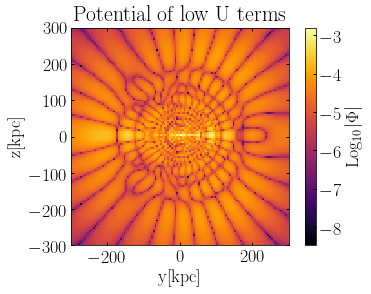

In [265]:
title('Potential of low U terms')
imshow(np.log10(np.abs(pot_matrix_low.T)), extent = [-300, 300, -300, 300],
       origin='lower', cmap='inferno')
xlabel('y[kpc]')
ylabel('z[kpc]')
cbar = colorbar()
cbar.set_label(r'$\rm{Log_{10} |\Phi|}$')
savefig('potential_of_low_u_terms.pdf')

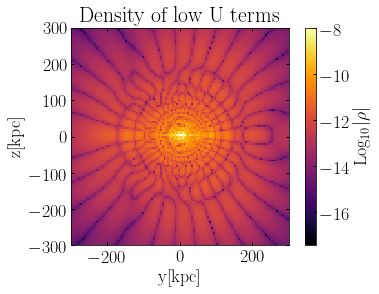

In [581]:
title('Density of low U terms')
imshow(np.log10(np.abs(dens_matrix_low).T), 
       extent = [-300, 300, -300, 300],
       origin='lower', cmap='inferno')
xlabel('y[kpc]')
ylabel('z[kpc]')
cbar = colorbar()
cbar.set_label(r'$\rm{Log_{10} |\rho|}$')
savefig('density_of_low_u_terms.pdf')